In [18]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

# Deep learning
import sys
!{sys.executable} -m pip install --upgrade pip setuptools wheel
!{sys.executable} -m pip install tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

RSEED = 42
np.random.seed(RSEED)

In [19]:
# --- 1. load dataset
df = pd.read_csv("C:/Users/User/Desktop/Assignments/LAST SEM!!/Machine Learning/house-prices-advanced-regression-techniques/train.csv")
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Columns with missing values:


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

Total columns with missing values: 19


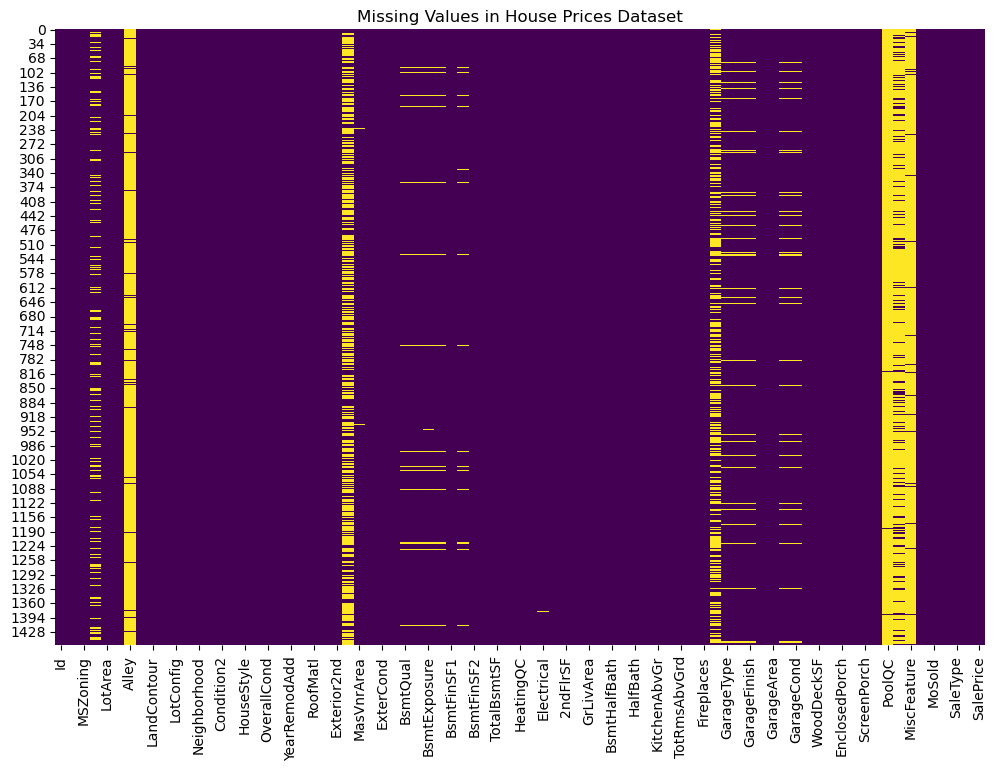

Top 10 features with most missing values:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
dtype: int64


In [20]:
#2. Check Missing Values
# Check which columns contain missing data
missing_counts = df.isnull().sum()
missing = missing_counts[missing_counts > 0].sort_values(ascending=False)
print("Columns with missing values:")
display(missing.head(20))
print("Total columns with missing values:", len(missing))

# Visualize missing
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in House Prices Dataset')
plt.show()

print("Top 10 features with most missing values:")
print(df.isnull().sum().sort_values(ascending=False).head(10))

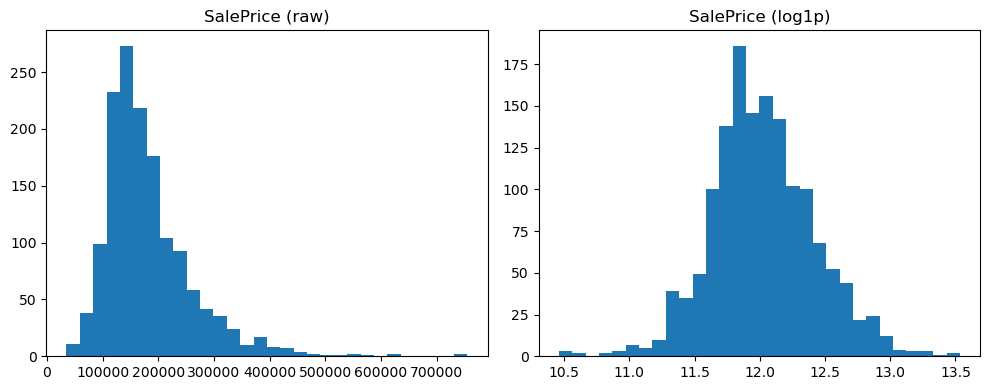

In [21]:
# 3. Imbalance handling using log trnasform
target = "SalePrice"
# show distribution before/after log-transform
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.hist(df[target], bins=30); plt.title("SalePrice (raw)")
plt.subplot(1,2,2); plt.hist(np.log1p(df[target]), bins=30); plt.title("SalePrice (log1p)")
plt.tight_layout(); plt.show()

# apply log transform to reduce skewness (managing "imbalance" in regression target)
df[target + "_log"] = np.log1p(df[target])

# drop Id
if 'Id' in df.columns: df.drop(columns=['Id'], inplace=True)

# features and target
X = df.drop(columns=[target, target + "_log"])
y = df[target + "_log"]

In [22]:
#4. Basic filtering and splits
keep_cols = [c for c in X.columns if X[c].nunique() > 1 and X[c].isna().mean() < 0.8]
X = X[keep_cols]
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"Num features: {len(num_cols)}, Cat features: {len(cat_cols)}")

# preprocessing pipelines
num_pipeline = Pipeline([('impute', SimpleImputer(strategy='median')), ('scale', StandardScaler())])
cat_pipeline = Pipeline([('impute', SimpleImputer(strategy='most_frequent')), ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
preprocessor = ColumnTransformer([('num', num_pipeline, num_cols), ('cat', cat_pipeline, cat_cols)], remainder='drop')

X_trans = preprocessor.fit_transform(X)
print("Transformed shape:", X_trans.shape)

# train/test split (reproducible)
X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size=0.2, random_state=RSEED)

# helper to evaluate on original price scale
def eval_regression(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

Num features: 36, Cat features: 39
Transformed shape: (1460, 274)


In [23]:
#6. RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200, random_state=RSEED, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf_log = rf.predict(X_test)
metrics_rf_base = eval_regression(y_test, y_pred_rf_log)
print("RandomForest baseline (un-tuned):", metrics_rf_base)

RandomForest baseline (un-tuned): {'RMSE': np.float64(28766.145542049173), 'MAE': 17296.950684899395, 'R2': 0.8921178699582565}


In [24]:
#7. Tunning for RandomForest (GridSearchCV)
rf_params = {'n_estimators':[100,200], 'max_depth':[None,10,20], 'min_samples_split':[2,5]}
rf_gs = GridSearchCV(RandomForestRegressor(random_state=RSEED, n_jobs=-1), rf_params, cv=3, scoring='r2', n_jobs=-1)
rf_gs.fit(X_train, y_train)
print("RF best params:", rf_gs.best_params_)
rf_best = rf_gs.best_estimator_
y_pred_rf_best_log = rf_best.predict(X_test)
metrics_rf_tuned = eval_regression(y_test, y_pred_rf_best_log)
print("RandomForest tuned:", metrics_rf_tuned)

RF best params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
RandomForest tuned: {'RMSE': np.float64(29297.663849785837), 'MAE': 17388.986674906893, 'R2': 0.8880943151738753}


In [25]:
#8 ANN regressor
input_dim = X_train.shape[1]

def build_ann_reg(input_dim, lr=1e-3):
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.2),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.15),
        Dense(64, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(lr), loss='mse', metrics=['mae'])
    return model

# Simple ANN tuning loop (learning rate & batch) -> pick best by validation loss
ann_best = None
best_val = float('inf')
ann_hist_best = None
for lr in [1e-3, 5e-4]:
    for batch in [64, 128]:
        model = build_ann_reg(input_dim, lr=lr)
        es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=0)
        history = model.fit(X_train, y_train, validation_split=0.15, epochs=100, batch_size=batch, callbacks=[es], verbose=0)
        val_loss = min(history.history['val_loss'])
        print(f"ANN trial lr={lr}, batch={batch} -> best val_loss={val_loss:.6f}")
        if val_loss < best_val:
            best_val = val_loss
            ann_best = model
            ann_hist_best = history

# Evaluate chosen ANN
y_pred_ann_log = ann_best.predict(X_test).ravel()
metrics_ann = eval_regression(y_test, y_pred_ann_log)
print("ANN (best) metrics:", metrics_ann)

ANN trial lr=0.001, batch=64 -> best val_loss=0.139241
ANN trial lr=0.001, batch=128 -> best val_loss=0.119230
ANN trial lr=0.0005, batch=64 -> best val_loss=0.156614
ANN trial lr=0.0005, batch=128 -> best val_loss=0.123213
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
ANN (best) metrics: {'RMSE': np.float64(78989.1041789596), 'MAE': 51209.03387200343, 'R2': 0.1865693308912597}


,RMSE,MAE,R2
RandomForest_Tuned,29297.663850,17388.986675,0.888094
ANN,78989.104179,51209.033872,0.186569


Best model: RandomForest_Tuned


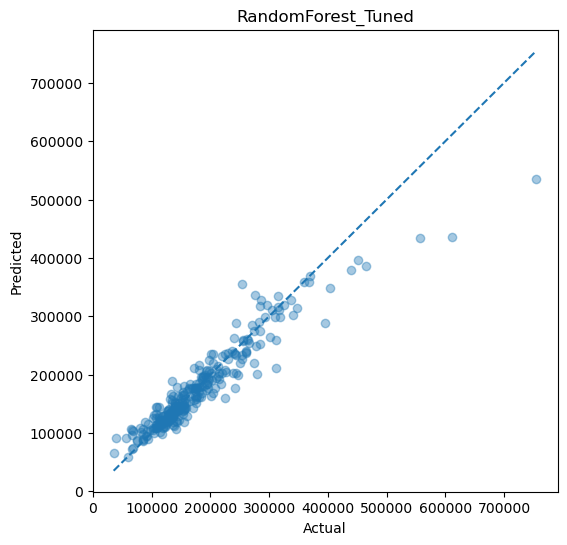

,feature,importance
3,OverallQual,0.405370
15,GrLivArea,0.135494
11,TotalBsmtSF,0.034340
25,GarageCars,0.018662
12,1stFlrSF,0.011224
8,BsmtFinSF1,0.010702
26,GarageArea,0.008411
5,YearBuilt,0.007666
4,OverallCond,0.007044
2,LotArea,0.006785


In [26]:
import pandas as pd
compare = pd.DataFrame([metrics_rf_tuned, metrics_ann], index=['RandomForest_Tuned','ANN'])
display(compare)

# Plot Predicted vs Actual for best
best_model_name = compare['RMSE'].idxmin()
print("Best model:", best_model_name)
y_pred_best = np.expm1(y_pred_rf_best_log) if best_model_name.startswith('RandomForest') else np.expm1(y_pred_ann_log)
y_test_orig = np.expm1(y_test)
plt.figure(figsize=(6,6)); plt.scatter(y_test_orig, y_pred_best, alpha=0.4)
lims=[min(y_test_orig.min(), y_pred_best.min()), max(y_test_orig.max(), y_pred_best.max())]
plt.plot(lims, lims, '--'); plt.xlabel('Actual'); plt.ylabel('Predicted'); plt.title(best_model_name); plt.show()

# Feature importance (RF)
perm = permutation_importance(rf_best, X_test, y_test, n_repeats=10, random_state=RSEED, n_jobs=-1)
if cat_cols:
    ohe = preprocessor.named_transformers_['cat'].named_steps['ohe']
    cat_ohe_names = ohe.get_feature_names_out(cat_cols)
    feature_names = num_cols + list(cat_ohe_names)
else:
    feature_names = num_cols
imp_df = pd.DataFrame({'feature':feature_names,'importance':perm.importances_mean}).sort_values('importance',ascending=False)
display(imp_df.head(15))